#### CraftDemo from Reddit
- Classification task
    - https://www.1point3acres.com/bbs/thread-1083555-1-1.html
- 数据类似：
    - there're 3 categories A, B, C; each row represent a user; 一共有几千行，数据是balance的，没有missing
        - col1 = time watching A
        - col2 = time watching B
        - col3 = time watching C
        - col4 = a category presented (A, B, or C)
        - col5 = 1 if user clicked category presented in 4 else 0

In [13]:
# Step1: Try to generate your own dataset based on the above requirements
import pandas as pd
import numpy as np

samples = 5000
categories = ['A', 'B', 'C']
click_prob = {
    'A':[0.8, 0.1, 0.1],
    'B':[0.1,0.8,0.1],
    'C':[0.1,0.1,0.8]
}
time_A = np.random.randint(0,10000, size=samples)
time_B = np.random.randint(0,10000, size=samples)
time_C = np.random.randint(0,10000, size=samples)

presented_category = np.random.choice(categories, size=samples)

clicks = []
for i in range(samples):
    cat = presented_category[i] # 'A' 'B' 'C'
    prob_i = click_prob[cat] # [0.8, 0.1, 0.1]
    clicks.append(np.random.choice([0,1], p=[1-prob_i[categories.index(cat)], prob_i[categories.index(cat)]]))

df = pd.DataFrame({
    'timeA': time_A,
    'timeB': time_B,
    'timeC': time_C,
    'category': presented_category,
    'clicked': clicks
})

df_encoded = pd.get_dummies(df, columns=['category'])
df_encoded.head()

,timeA,timeB,timeC,clicked,category_A,category_B,category_C
0,5859,3268,9796,1,0,0,1
1,1251,5041,6103,1,0,0,1
2,1213,1970,7115,1,1,0,0
3,6747,3337,207,1,1,0,0
4,4408,4277,8573,1,0,0,1


In [14]:
# Step2: My first insuition is to build a Logistic Regression model as our baseline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X, Y = df_encoded.drop(columns=['clicked']), df_encoded['clicked']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
log_reg = LogisticRegression(max_iter=150)
model = log_reg.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print("Baseline Acc: {}".format(score))


Baseline Acc: 0.807


In [29]:
# Step3: MLP Classifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(128, 64), (256, 128, 64)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001],
}

mlp = MLPClassifier(max_iter=500, random_state=42, early_stopping=True)
# mlp.fit(X_train, y_train)
# mlp_predict = mlp.predict(X_test)
# mlp_score = accuracy_score(y_test, mlp_predict)
# print("MLP Acc: {}".format(mlp_score))

grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_mlp = grid_search.best_estimator_
y_pred_test = best_mlp.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy with Best MLP: {test_accuracy:.4f}")
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate_init': 0.01}


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# Print detailed classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       193
           1       0.81      1.00      0.89       807

    accuracy                           0.81      1000
   macro avg       0.40      0.50      0.45      1000
weighted avg       0.65      0.81      0.72      1000

Confusion Matrix:
[[  0 193]
 [  0 807]]


c:\Users\JadeSun\anaconda3\envs\retinal_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JadeSun\anaconda3\envs\retinal_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JadeSun\anaconda3\envs\retinal_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

#### Decision Boundary

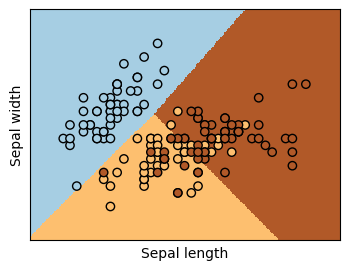

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

# Using a well-known iris dataset
iris = datasets.load_iris()
X = iris.data[:, :2]  # Using only 2 features for visualization purposes
Y = iris.target

# Logistics Regression model
model = LogisticRegression(solver='liblinear',C=1e5)
model.fit(X, Y)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()